In [186]:
#Data wrangling
import pandas as pd 

#Linear Algebra
import numpy as np 


#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')

In [187]:
path = 'Datasets/alcohol_sales/'

In [188]:
import os

In [189]:
os.listdir(path)

['Alcohol_Sales.csv',
 'BeerWineLiquor.csv',
 'Deep Learning for Time Series Forecasting.png',
 'energydata_complete.csv',
 'Miles_Traveled.csv',
 'prophet_facebook2.png']

In [190]:
data = pd.read_csv(path+'BeerWineLiquor.csv')

In [191]:
data

,date,beer
0,1/1/1992,1509
1,2/1/1992,1541
2,3/1/1992,1597
3,4/1/1992,1675
4,5/1/1992,1822
...,...,...
319,8/1/2018,4898
320,9/1/2018,4598
321,10/1/2018,4737
322,11/1/2018,5130


In [192]:
data['date'] = pd.to_datetime(data['date'])

In [193]:
data.set_index(data['date'], inplace = True)

In [194]:
del data['date']

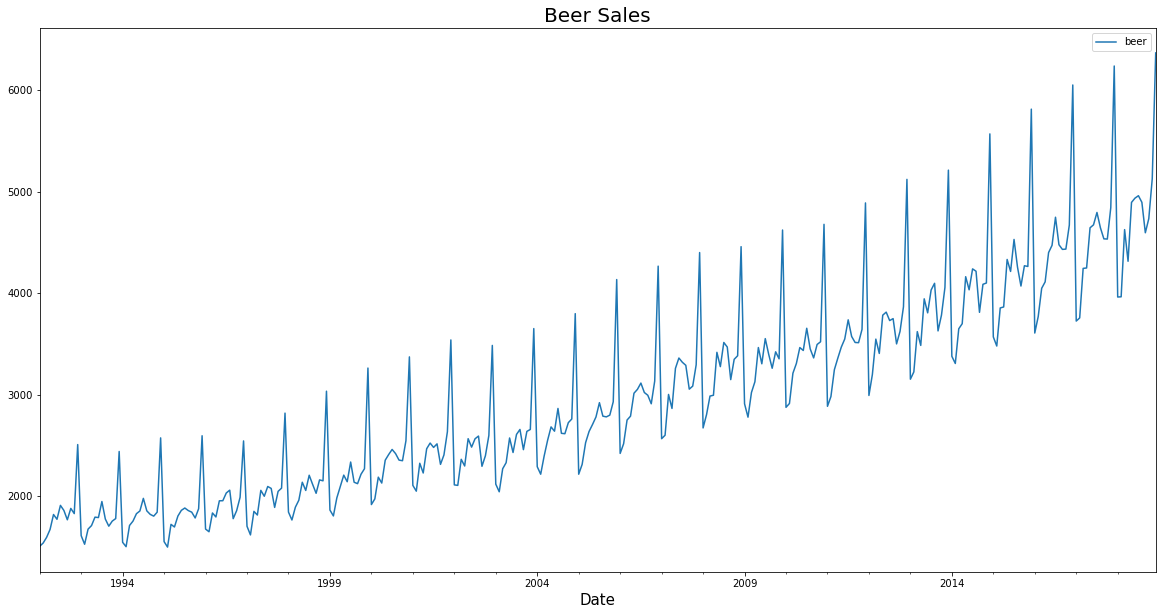

In [195]:
#Plotting the time series

data.plot(figsize = (20,10))
plt.title('Beer Sales', size = 20)
plt.xlabel('Date', size = 15)

plt.show()

### Checking stationarity

In [196]:
def test_stationarity(time_series):
    import statsmodels.tsa.stattools as sts
    
    dful  = sts.adfuller(time_series)
    print("Test statistic: {}".format(dful[0]))
    print("p-value: {}".format(dful[1]))
    print("#Lags Used: {}".format(dful[2]))
    print("#Observations used: {}".format(dful[3]))
    
    print("Critical values:")
    print("\t 1%: {}".format(dful[4]['1%']))
    print("\t 5%: {}".format(dful[4]['5%']))
    print("\t 10%: {}".format(dful[4]['10%']))
    
    print("Maximized information criteria: {}".format(dful[5]))

In [197]:
test_stationarity(data.beer)

Test statistic: 2.864308507897272
p-value: 1.0
#Lags Used: 15
#Observations used: 308
Critical values:
	 1%: -3.45176116018037
	 5%: -2.870970093607691
	 10%: -2.571794416006072
Maximized information criteria: 3570.218090367952


As usual, we generate the returns column with the change rate of each value

In [198]:
data['returns'] = data.beer.pct_change()*100

In [199]:
test_stationarity(data.returns[1:])

Test statistic: -4.407228756589489
p-value: 0.0002882098104123663
#Lags Used: 14
#Observations used: 308
Critical values:
	 1%: -3.45176116018037
	 5%: -2.870970093607691
	 10%: -2.571794416006072
Maximized information criteria: 1517.143306703323


Done!

In [200]:
from statsmodels.tsa.seasonal import seasonal_decompose

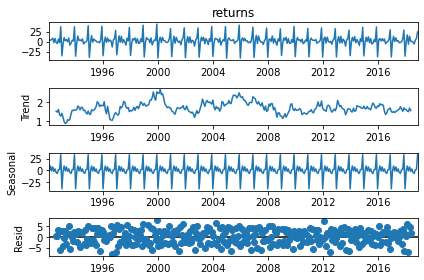

In [201]:
seasonal_decompose(data.returns[1:]).plot()
plt.show()

# Model construction

We've seen seasonality, so we'll build:

- SARMA
- SARIMA

In [202]:
#Statistical libraries
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts

#Models 
from statsmodels.tsa.arima_model import ARMA, ARIMA

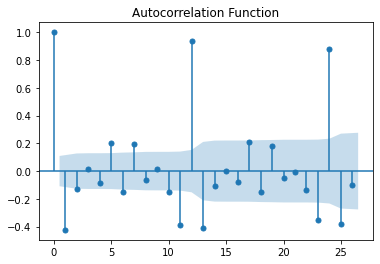

In [203]:
sgt.plot_acf(data.returns[1:])
plt.title('Autocorrelation Function')
plt.show()

We'll take 3 coefficients for the Moving Average model. This plot is telling us that there are seasonal effects

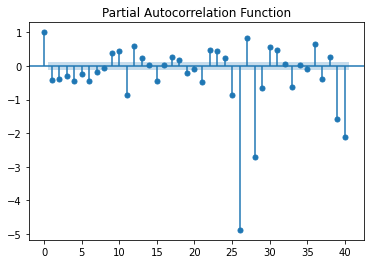

In [204]:
sgt.plot_pacf(data.returns[1:], lags = 40)
plt.title('Partial Autocorrelation Function')
plt.show()

We would expect the values to be ranged from -1 to 1. Since I'm not sure why this happens, one possibility is that there is a structure underlying the data that is redundant, causing this obviously wrong correlation. To be cautious, we'll try the first few coefficients to build our Autoregressive model.

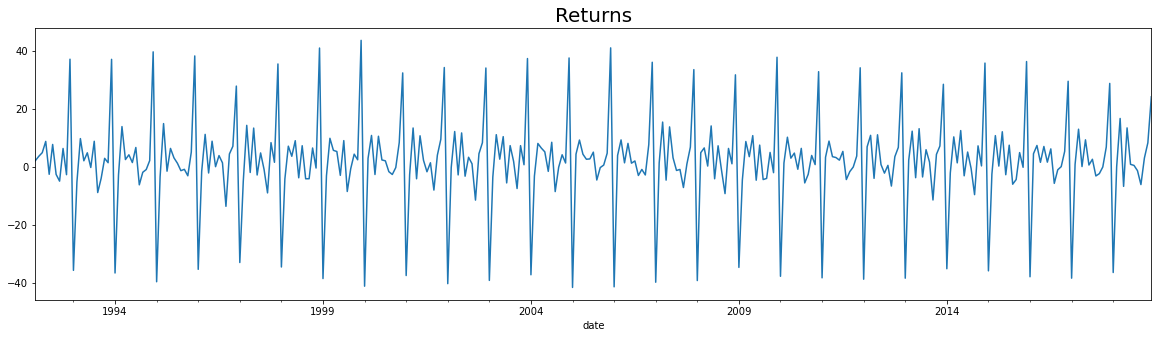

In [205]:
data.returns[1:].plot(figsize = (20,5))
plt.title('Returns', size = 20)
plt.show()

# Data Split

In [206]:
training = int(len(data)*0.7)

df, df_test = data.iloc[:training], data.iloc[training:]

In [207]:
#dates

print(df_test.head(1).index)
print(df_test.tail(1).index)

DatetimeIndex(['2010-11-01'], dtype='datetime64[ns]', name='date', freq=None)
DatetimeIndex(['2018-12-01'], dtype='datetime64[ns]', name='date', freq=None)


In [208]:
start_date = '2010-11-01'
end_date = '2018-12-01'

# AutoRegressive Model

In [209]:
ar_2 = ARMA(df.returns[1:], order = (2,0))

model_ar = ar_2.fit()

pred_ar = model_ar.predict(start = start_date, end = end_date)

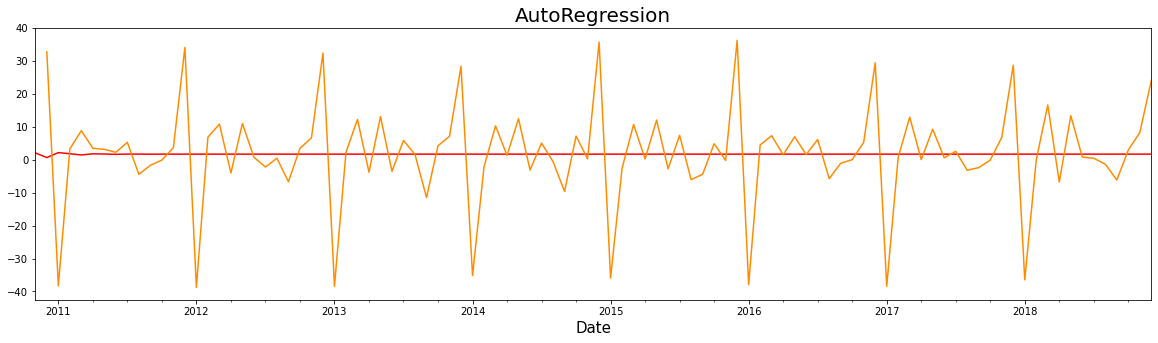

In [210]:
plt.figure(figsize = (20,5))

pred_ar.plot(label = 'AR(2)', color = 'red')
df_test.returns[1:].plot(color  = 'DarkOrange')

plt.title('AutoRegression', size = 20)
plt.xlabel('Date', size = 15)
plt.show()

Nope

# Moving Average Model

In [211]:
ma_3 = ARMA(df.returns[1:], order = (3,0))

model_ma = ma_3.fit()

pred_ma = model_ma.predict(start = start_date, end = end_date)

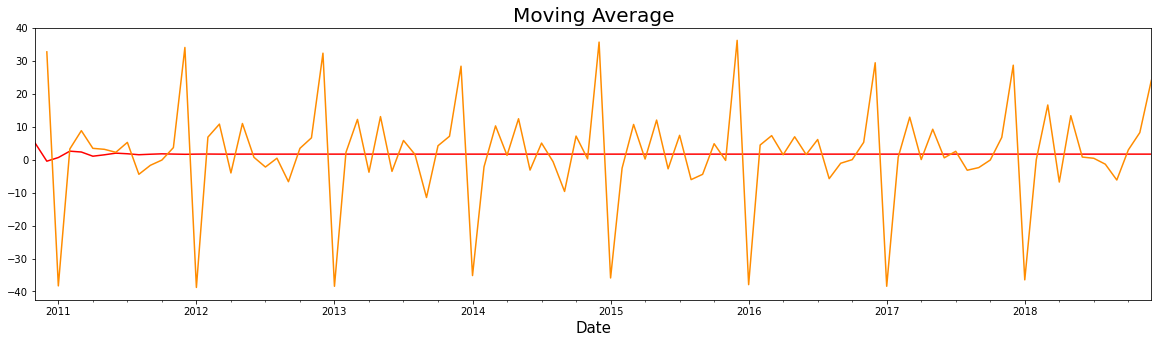

In [212]:
plt.figure(figsize = (20,5))

pred_ma.plot(label = 'AR(2)', color = 'red')
df_test.returns[1:].plot(color  = 'DarkOrange')

plt.title('Moving Average', size = 20)
plt.xlabel('Date', size = 15)
plt.show()

Nope  x2

# ARMA

In [213]:
from statsmodels.tsa.arima_model import ARMA

In [230]:
arma_23 = ARMA(df.returns[1:], order = (2,6))

model_arma = arma_23.fit()

pred_arma = model_arma.predict(start = start_date, end = end_date)

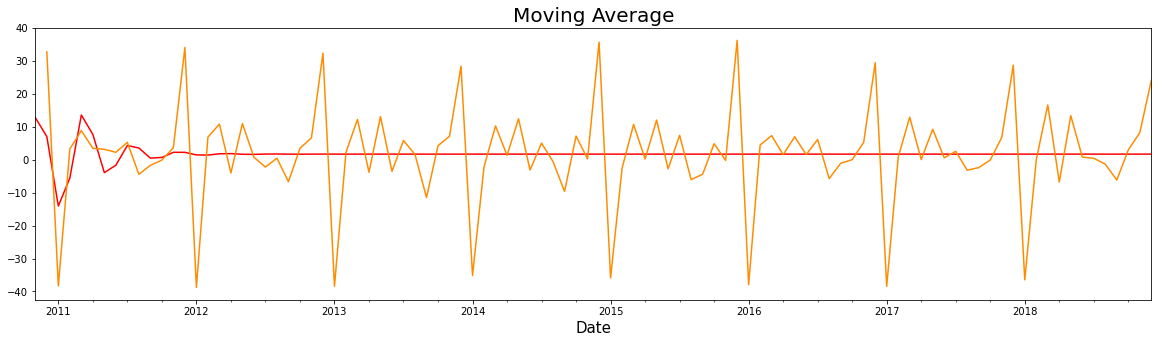

In [231]:
plt.figure(figsize = (20,5))

pred_arma.plot(label = 'ARMA(2,3)', color = 'red')
df_test.returns[1:].plot(color  = 'DarkOrange')

plt.title('Moving Average', size = 20)
plt.xlabel('Date', size = 15)
plt.show()

Nope x3. It starts "promising" but quickly flattens.

# ARIMA

In [216]:
from statsmodels.tsa.arima_model import ARIMA

In [227]:
arima = ARIMA(df.returns[1:], order = (2,1,6))

model_arima = arima.fit()

pred_arima = model_arima.predict(start = start_date, end = end_date)

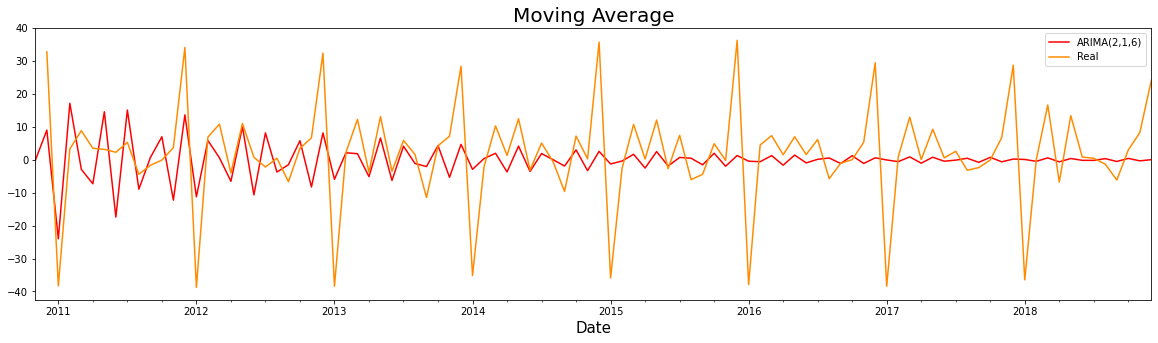

In [229]:
plt.figure(figsize = (20,5))

pred_arima.plot(label = 'ARIMA(2,1,6)', color = 'red')

df_test.returns[1:].plot(color  = 'DarkOrange', label = 'Real')

plt.title('Moving Average', size = 20)
plt.legend()
plt.xlabel('Date', size = 15)
plt.show()

Starts better than all the previous models, but falls into the same flat line, even though it casts some good predictions.

# SARIMA 

Just to recall, lets see the beer sales plot once more.

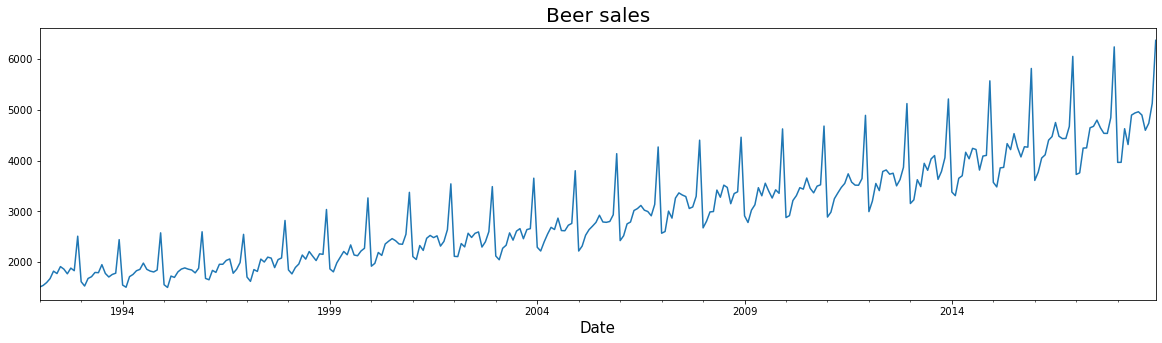

In [219]:
data.beer.plot(figsize=(20,5))

plt.xlabel('Date', size = 15)
plt.title('Beer sales', size = 20)

plt.show()

There is a minimum starting a cycle yearly. Since the data is registered monthly, it'll take 12 points to see cyclical effects repeat themselves.

In [220]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Since we don't have any exogenous variables what will be implemented will be a SARIMA or a SARMA model.

## SARMA

In [221]:
sarma = SARIMAX(df.returns[1:], order = (3,0,2), seasonal_order = (1,0,1,12),
                initialization='approximate_diffuse')

model_sarma = sarma.fit()

pred_sarma = model_sarma.predict(start = start_date, end = end_date)

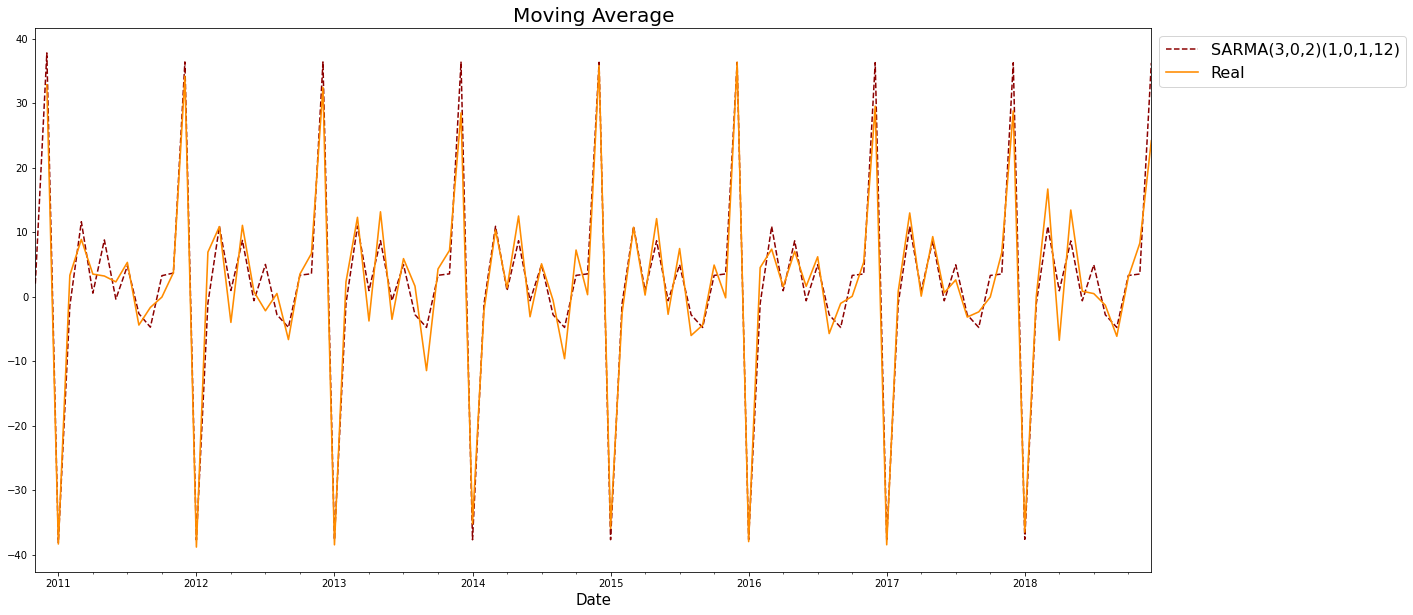

In [223]:
plt.figure(figsize = (20,10))

pred_sarma.plot(label = 'SARMA(3,0,2)(1,0,1,12)', color = 'DarkRed', linestyle = 'dashed')

df_test.returns[1:].plot(label ='Real',color  = 'DarkOrange', linewidth = 1.6)


plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', prop={'size': 16})
plt.title('Moving Average', size = 20)
plt.xlabel('Date', size = 15)
plt.show()

Really good results without an integration step!

# Final Conclusions

It is clear that the SARIMA is the model to go with. What remains is to toy with the coefficients a little bit to try and improve it even further.